In [1]:
# import dependencies for analysis
import autograd.numpy as np
from autograd import grad
import pandas as pd
import scipy.io as io
from sklearn.model_selection import train_test_split

In [2]:
# set up task parameters
# we have 5 TF changes + 1 no change = 6 states 
# mus represents the mean TF of each change:
mus = np.log2([1.0, 1.25, 1.35, 1.5, 2.0, 4.0])
nz = 6

# import dependencies for plots
import matplotlib.pyplot as plt
plt.rc('font', family='Arial')
import seaborn as sns

In [3]:
def transition_matrix(h_t):
    """
    Define transition probabilities p( z_{t} ) | p( z_{t-1} )
    """
    T = np.identity(nz)
    T[0, 0] = 1 - h_t
    T[0, 1:] = h_t / nz
    return T

In [4]:
def emission_probability(x, sigma):
    """
    Define emission probabilities for each state p( x | z)
    """
    p = np.exp(-(x - mus)**2 / (2 * sigma**2)) / np.sqrt(2 * np.pi * sigma**2)
    return p

In [5]:
def update_joint(x_t, h_t, z, sigma_sensory, sigma_total):
    """
    Update joint probability following HMM forward pass equations
    """
    p_x = emission_probability(x_t + np.random.normal()*sigma_sensory, sigma_total )
    p_x_z = p_x * np.matmul(z, h_t)
    return p_x_z

In [6]:
def get_posterior(xvec, h, sigma_sensory, sigma_total):
    """
    Get posterior probability
    """
    p_joint = np.concatenate((np.array([1]), np.repeat(0, nz-1)))
    p_z = [p_joint]
    for ii in range(1, xvec.shape[0]):
        p_joint = update_joint(xvec[ii], h, p_joint, sigma_sensory, sigma_total)
        p_x = np.sum(p_joint)
        p_joint = p_joint / p_x
        p_z.append(p_joint)
    p_z = np.stack(p_z, axis=0)
    return p_z

In [7]:
# import dependencies to use for plots
import numpy as np
import matplotlib
from sklearn.linear_model import LinearRegression
import seaborn as sns

In [8]:
def compute_trials(h=0.0072, ntrials=1000, change=0, nsamples=80, sigma_sensory=0.):
    sigma_x = 0.25
    xvec = np.random.normal( size=(nsamples,ntrials) ) * sigma_x
    xvec[-40:,:] += change
    sigma_total = np.sqrt(sigma_x ** 2 + sigma_sensory ** 2)
    p_z = np.zeros( shape=(nsamples, nz, ntrials) )
    for ii in range(0,ntrials):
        p_z[:,:,ii] = get_posterior(xvec[:,ii], transition_matrix(h), sigma_sensory, sigma_total)
    return p_z, xvec

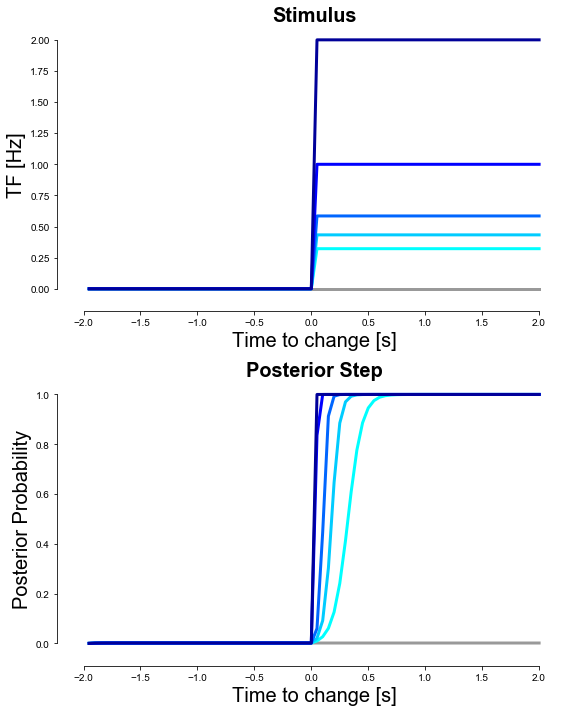

In [9]:
# ignore jupyter warnings
import warnings
warnings.filterwarnings('ignore')

t = np.linspace(-1.95, 2.0, num=80)
xvec = np.zeros(shape=(80,))
plt.figure(figsize=(8,10))

colors = [[153, 153, 153],
              [0, 255, 255],
              [0, 204, 255],
              [0, 102, 255],
              [0, 0, 255],
              [0, 0, 153]]

for ii, mu in enumerate(mus):
    xvec[40:] = mu
    plt.subplot(2,1,1)
    plt.plot(t, xvec, color=np.array(colors[ii])/255, linewidth=3)
    plt.ylabel('TF [Hz]', fontsize=20 )
    plt.xlabel('Time to change [s]', fontsize=20 )
    plt.title('Stimulus', fontsize=20, fontweight='bold')
    
    p_z = get_posterior(xvec, transition_matrix(0.0072), 0., 0.25)
    plt.subplot(2,1,2)
    plt.plot(t, np.sum(p_z[:,1:], axis=1) , color=np.array(colors[ii])/255, linewidth=3)
    plt.ylabel('Posterior Probability', fontsize=20 )
    plt.xlabel('Time to change [s]', fontsize=20 )
    plt.title('Posterior Step', fontsize=20, fontweight='bold')
    
sns.despine(trim=True, offset=10)
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.tight_layout()  
#plt.savefig("example.pdf")

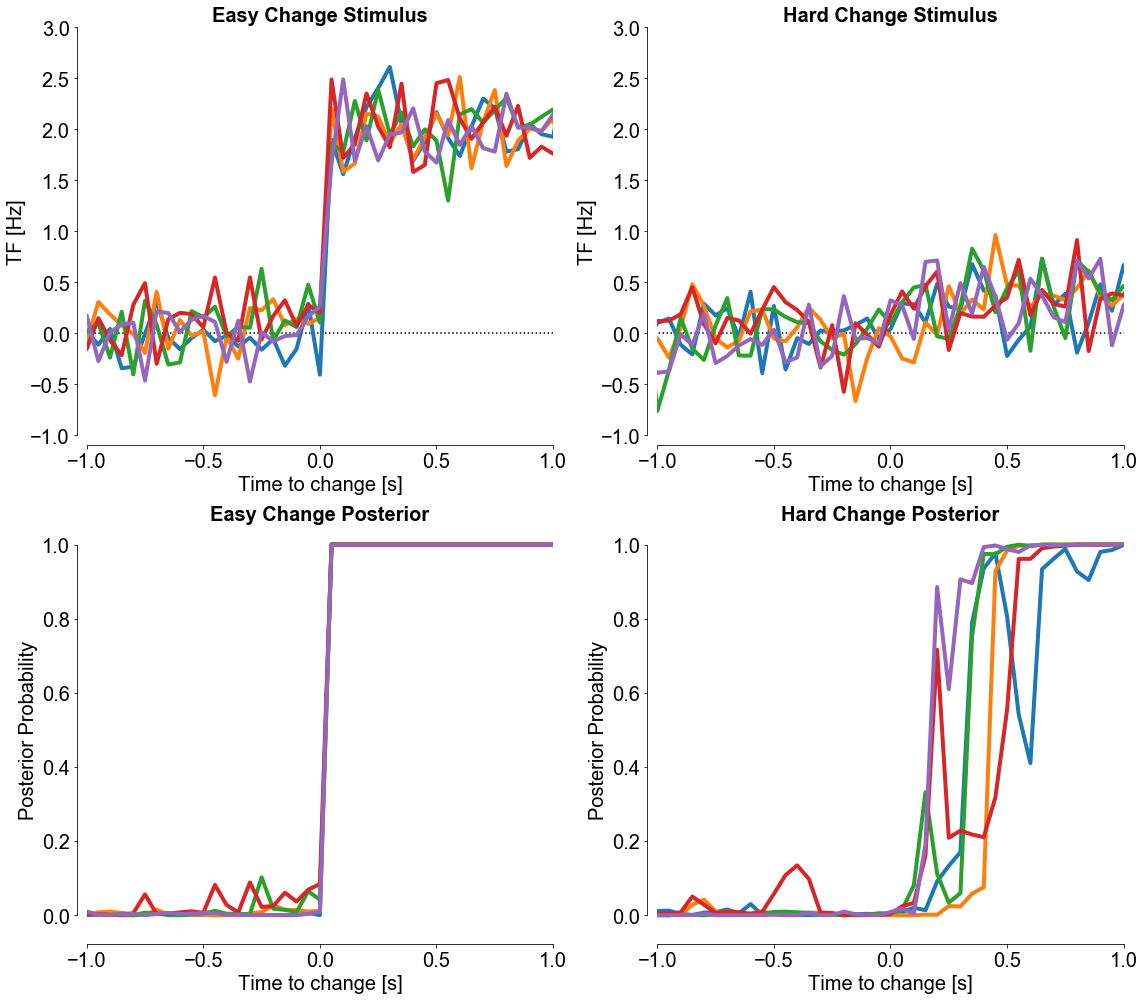

In [10]:
# easy vs hard changes
plt.figure(figsize=(16,14))

# plot 5 examples of easy change 
np.random.seed(1)
(p_z_easy, x_easy) = compute_trials(ntrials=5, change=np.log2(4))
p_change_easy = np.sum(p_z_easy[:,1:,:], 1)
plt.subplot(2,2,1)
plt.plot([t[0], t[-1]], [0,0], color='k', linestyle=':')
plt.plot(t, x_easy, linewidth='4')
plt.xlim([-1., 1.])
plt.ylim([-1, 3])
plt.ylabel('TF [Hz]', fontsize=20 )
plt.xlabel('Time to change [s]', fontsize=20 )
plt.title('Easy Change Stimulus', fontsize=20, fontweight='bold')

# plot 5 corresponding posterior probabilities of easy change
plt.subplot(2,2,3)
plt.plot(t, p_change_easy, linewidth='4')
plt.xlim([-1., 1.])
plt.ylabel('Posterior Probability', fontsize=20 )
plt.xlabel('Time to change [s]', fontsize=20 )
plt.title('Easy Change Posterior', fontsize=20, fontweight='bold')

# plot 5 examples of hard change
(p_z_hard, x_hard) = compute_trials(ntrials=5, change=np.log2(1.25))
p_change_hard = np.sum(p_z_hard[:,1:,:], 1)
plt.subplot(2,2,2)
plt.plot( [t[0], t[-1]], [0,0], color='k', linestyle=':')
plt.plot(t, x_hard, linewidth='4')
plt.xlim([-1., 1.])
plt.ylim([-1, 3])
plt.ylabel('TF [Hz]', fontsize=20 )
plt.xlabel('Time to change [s]', fontsize=20 )
plt.title('Hard Change Stimulus', fontsize=20, fontweight='bold')

# plot 5 corresponding posterior probabilities of hard change
plt.subplot(2,2,4)
plt.plot(t, p_change_hard, linewidth='4')
plt.xlim([-1., 1.])
plt.ylabel('Posterior Probability', fontsize=20 )
plt.xlabel('Time to change [s]', fontsize=20 )
plt.title('Hard Change Posterior', fontsize=20, fontweight='bold')

sns.despine(trim=True, offset=10)
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.tight_layout()    


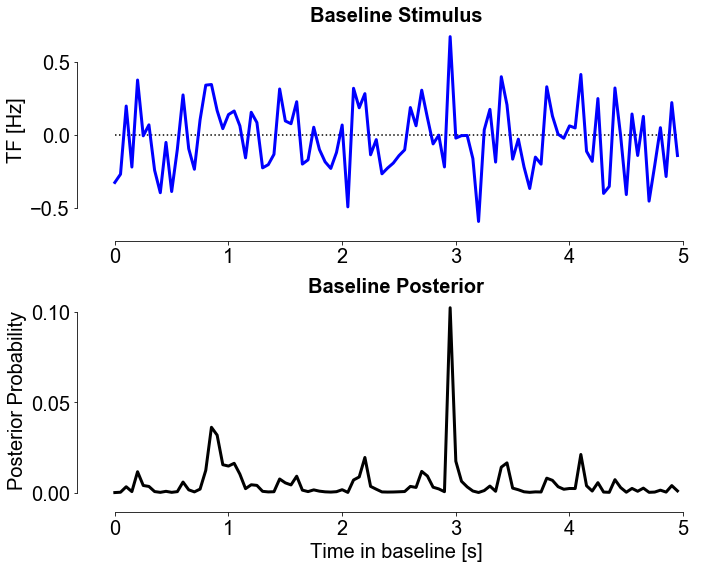

In [11]:
# baseline
plt.figure(figsize=(10,8))

np.random.seed(1111)
(p_z, x) = compute_trials(ntrials=1, change=0, nsamples=100, h=0.0072)
p_change = np.sum( p_z[:,1:,:], 1 )
t = 0.05 * np.arange(100)

# plot baseline stimulus
plt.subplot(2,1,1)
plt.plot( [t[0], t[-1]], [0., 0.], color='black', linestyle=':' )
plt.plot(t, x, color='blue', linewidth='3')
plt.ylabel('TF [Hz]', fontsize=20 )

plt.title('Baseline Stimulus', fontsize=20, fontweight='bold')

# plot corresponding posterior
plt.subplot(2,1,2)
plt.plot(t, p_change, color='black', linewidth = '3')
plt.ylabel('Posterior Probability', fontsize=20 )
plt.xlabel('Time in baseline [s]', fontsize=20 )
plt.title('Baseline Posterior', fontsize=20, fontweight='bold')

sns.despine(trim=True, offset=10)
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.tight_layout()    


In [12]:
# posterior stimulus extremes
# p_change is a vector 1 x 200
# r is a vector with values close to 200, ends at 199
# use threshold to only take values less than 200 - nlags 
def posterior_stimulus_extremes(h = 0.0072, thresh_min = .375, thresh_max = np.inf):
    (p_z, x) = compute_trials(ntrials=10000, change=0, nsamples=200, h=h)
    nlags = 31
    p_change = np.sum(p_z[:,1:,:], 1)
    lags = np.arange(0, nlags)
    (r, c) = np.nonzero(np.logical_and(x > thresh_min, x < thresh_max))

    idx = r<(200-nlags)
    r = r[idx]
    c = c[idx]

    z_mat = np.zeros(shape=(nlags, len(r)))
    for ii in range(len(r)):
        z_mat[:, ii] = p_change[r[ii]:r[ii]+nlags, c[ii]]

    return np.mean(z_mat, axis=1), lags

In [13]:
# fast and slow pulses in baseline
(fast, lags) = posterior_stimulus_extremes(h = 0.0072, thresh_min = .375)
(slow, lags) = posterior_stimulus_extremes(h = 0.0072, thresh_max = -.375, thresh_min=-np.inf)
(mid, lags) = posterior_stimulus_extremes(h = 0.0072, thresh_max = .25, thresh_min=-.25)

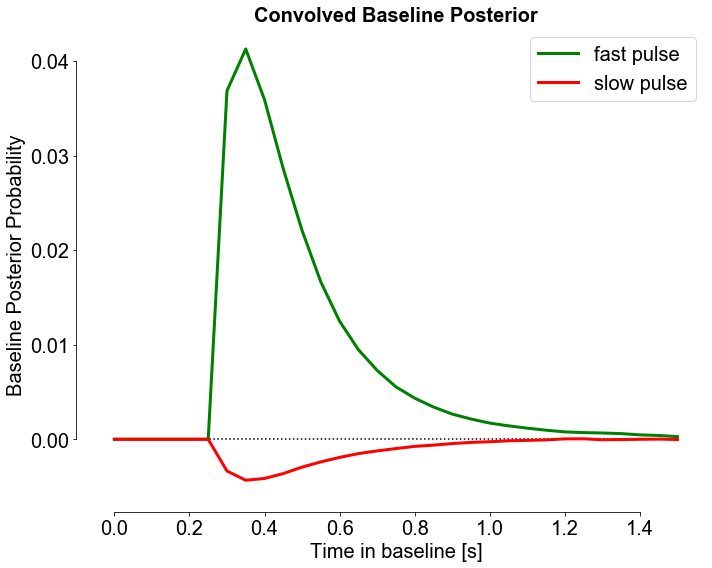

In [14]:
# plot fast vs slow pulses
plt.figure(figsize=(10,8))

t = 0.05 * lags
tau = 0.05
k = 2. ** (-t / tau)
k = k / np.sum(k)

fast_ca = np.concatenate((np.zeros(shape=(6)), np.convolve(k, fast-mid)[0:25]))
slow_ca = np.concatenate((np.zeros(shape=(6)), np.convolve(k, slow-mid)[0:25]))

plt.plot([t[0], t[-1]], [0,0], color='k', linestyle=':')
plt.plot(t, fast_ca, color='g', linewidth='3', label='fast pulse')
plt.plot(t, slow_ca, color='r', linewidth='3', label='slow pulse')
plt.ylabel('Baseline Posterior Probability', fontsize=20 )
plt.xlabel('Time in baseline [s]', fontsize=20 )
plt.title('Convolved Baseline Posterior', fontsize=20, fontweight='bold')
plt.legend(fontsize=20)

sns.despine(trim=True, offset=10)
plt.tight_layout()


In [15]:
# our posterior depends on 2 parameters: the weights (w) for each change and bias (p0) to lick for a change
# we will extract weights (w) and bias (lags or p0)
# side note:
# F order = Fortran-like order (first element changes fastest, last element changes slowest)

def posterior_history_dependence(h=0.0072, sigma_sensory=0.):
    (p_z, x) = compute_trials(ntrials=10000, change=0, nsamples=200, h=h, sigma_sensory=sigma_sensory)
    nlags = 31
    p_change = np.sum(p_z[nlags:,1:,:], 1)
    lags = np.arange(0, nlags)
    x_mat = np.zeros(shape=(200-nlags,10000,nlags))
    for ii, lag in enumerate(lags):
        x_mat[:,:,ii] = x[ii:200-nlags+ii,:]
        
    x_mat = np.reshape(x_mat, (-1, nlags), order='F')
    p_change = np.reshape(p_change, (-1), order='F')
    mdl = LinearRegression().fit(x_mat, p_change)
    weights = np.flip(mdl.coef_)
    return weights, lags


In [16]:
# compute posterior history parameters (weights and lags)
# explore role of hazard rate:
(weights, lags) = posterior_history_dependence(h=0.0072)
(weights_s, lags_s) = posterior_history_dependence(h=0.00072)

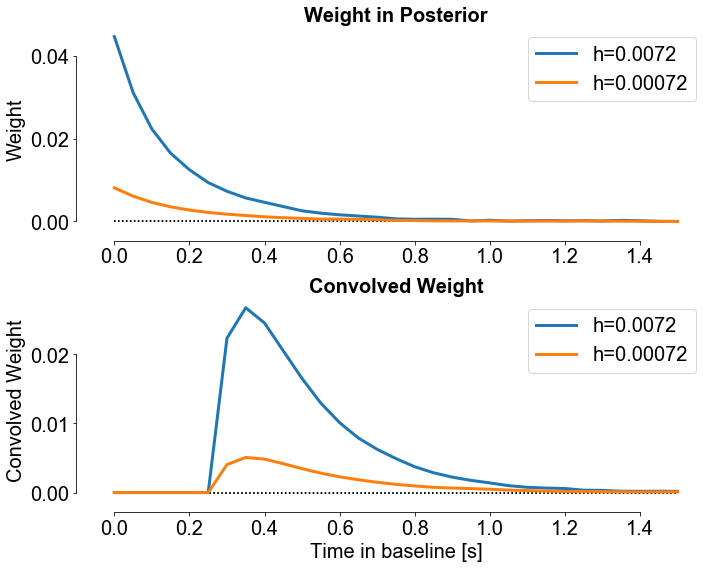

In [17]:
plt.figure(figsize=(10,8))

# plot posterior history parameters for h=0.0072
# plot weights
plt.subplot(2,1,1)
plt.plot([t[0], t[-1]], [0,0], color='k', linestyle=':')
plt.plot(t, weights, linewidth='3', label='h=0.0072')
plt.plot([t[0], t[-1]], [0,0], color='k', linestyle=':')
plt.plot(t, weights_s, linewidth='3', label='h=0.00072')
plt.ylabel('Weight', fontsize=20 )
plt.title('Weight in Posterior', fontsize=20, fontweight='bold')
plt.legend(fontsize=20)

# plot convolved weights
weights_ca = np.concatenate((np.zeros(shape=(6)), np.convolve(k, weights)[0:25]))
plt.subplot(2,1,2)
plt.plot([t[0], t[-1]], [0,0], color='k', linestyle=':')
plt.plot(t, weights_ca, linewidth='3', label='h=0.0072')
weights_ca_s= np.concatenate((np.zeros(shape=(6)), np.convolve(k, weights_s)[0:25]))
plt.subplot(2,1,2)
plt.plot([t[0], t[-1]], [0,0], color='k', linestyle=':')
plt.plot(t, weights_ca_s, linewidth='3', label='h=0.00072')
plt.ylabel('Convolved Weight', fontsize=20 )
plt.xlabel('Time in baseline [s]', fontsize=20 )
plt.title('Convolved Weight', fontsize=20, fontweight='bold')
plt.legend(fontsize=20)

sns.despine(trim=True, offset=10)
plt.tight_layout()
